# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [2]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [71]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))
print(X_dev.shape)

loss: 2.343540
sanity check: 2.302585
(500, 3073)


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** ¯\_(ツ)_/¯

Num classes = 10

\begin{equation}
Li = -log\frac{e^{s_{y_i}}}{\sum e^{s_j}}
\end{equation}

\begin{equation}
L = \frac{1}{N}\sum_{i=1}^{N} {Li + 𝜆𝑅(𝑊)}
\end{equation}

\begin{equation}
S[i,j] = X[i,k] * W[k,j] \approx X[i,k] * 0.0001
\end{equation}

\begin{equation}
Li = -log\frac{e^{s_{y_i}}}{\sum e^{s_j}} \approx -log\frac{1}{10}
\end{equation}

\begin{equation}
L = \frac{1}{N}\sum_{i=1}^{N} {Li + 𝜆𝑅(𝑊)} \approx \frac{1}{N}\sum_{i=1}^{N} {Li} \approx -log\frac{1}{10}
\end{equation}

In [59]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 0.026315 analytic: 0.026315, relative error: 2.418048e-06
numerical: 3.072806 analytic: 3.072806, relative error: 4.128566e-09
numerical: -5.471935 analytic: -5.471935, relative error: 1.953276e-09
numerical: -1.251300 analytic: -1.251300, relative error: 4.874658e-09
numerical: 2.753663 analytic: 2.753663, relative error: 2.924382e-08
numerical: -0.794089 analytic: -0.794089, relative error: 1.959418e-08
numerical: -0.309724 analytic: -0.309724, relative error: 1.455859e-07
numerical: 1.125268 analytic: 1.125268, relative error: 5.319627e-08
numerical: -3.921850 analytic: -3.921850, relative error: 9.246333e-10
numerical: -0.525332 analytic: -0.525332, relative error: 1.269781e-08
numerical: 0.980609 analytic: 0.980609, relative error: 3.633793e-08
numerical: -0.042890 analytic: -0.042890, relative error: 7.082676e-07
numerical: -1.113164 analytic: -1.113164, relative error: 2.409432e-08
numerical: 2.213901 analytic: 2.213901, relative error: 2.307133e-08
numerical: 0.76500

In [62]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.337960e+00 computed in 21.733950s
vectorized loss: 2.337960e+00 computed in 0.008981s
Loss difference: 0.000000
Gradient difference: 0.000000


In [66]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
learning_rates = np.linspace(1e-7, 5e-7, 3)
regularization_strengths = np.linspace(2.5e4, 5e4, 5)
print("lr\t\treg\t\ttrain\t\tval")

for lr in learning_rates:
    for reg in regularization_strengths:
        svm = Softmax()
        svm.train(X_train, y_train, learning_rate=lr, reg=reg, num_iters=800, verbose=False)

        # compute accuracy
        train_accuracy = np.mean(y_train == svm.predict(X_train))
        val_accuracy = np.mean(y_val == svm.predict(X_val))
        print("%e\t%e\t%f\t%f" % (lr, reg, train_accuracy, val_accuracy))

        # store accuracy in dictionary
        results[(lr, reg)] = (train_accuracy, val_accuracy)

        # check if validation accuracy is best
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_softmax = svm
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr		reg		train		val
1.000000e-07	2.500000e+04	0.322082	0.337000
1.000000e-07	3.125000e+04	0.325204	0.341000
1.000000e-07	3.750000e+04	0.331633	0.333000
1.000000e-07	4.375000e+04	0.336265	0.345000
1.000000e-07	5.000000e+04	0.329714	0.342000
3.000000e-07	2.500000e+04	0.351000	0.348000
3.000000e-07	3.125000e+04	0.344653	0.345000
3.000000e-07	3.750000e+04	0.343367	0.354000
3.000000e-07	4.375000e+04	0.332347	0.338000
3.000000e-07	5.000000e+04	0.327327	0.345000
5.000000e-07	2.500000e+04	0.347306	0.356000
5.000000e-07	3.125000e+04	0.333265	0.347000
5.000000e-07	3.750000e+04	0.338816	0.353000
5.000000e-07	4.375000e+04	0.333898	0.351000
5.000000e-07	5.000000e+04	0.326122	0.341000
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.322082 val accuracy: 0.337000
lr 1.000000e-07 reg 3.125000e+04 train accuracy: 0.325204 val accuracy: 0.341000
lr 1.000000e-07 reg 3.750000e+04 train accuracy: 0.331633 val accuracy: 0.333000
lr 1.000000e-07 reg 4.375000e+04 train accuracy: 0.336265 val accuracy: 0.345

In [67]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.355000


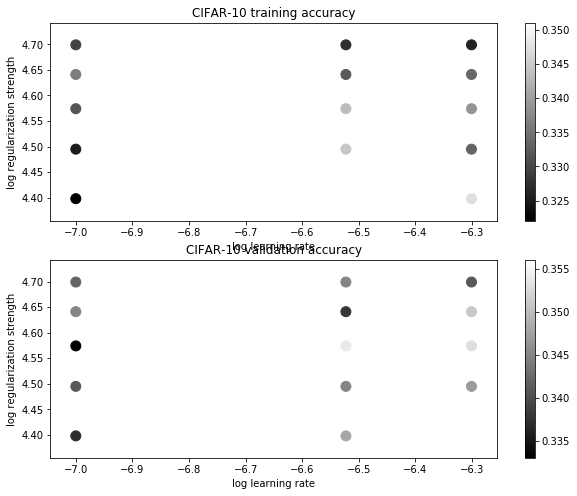

In [68]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

**Inline Question** - *True or False*

It's possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

*Your answer*: yes

*Your explanation*: pres 2 slide 25

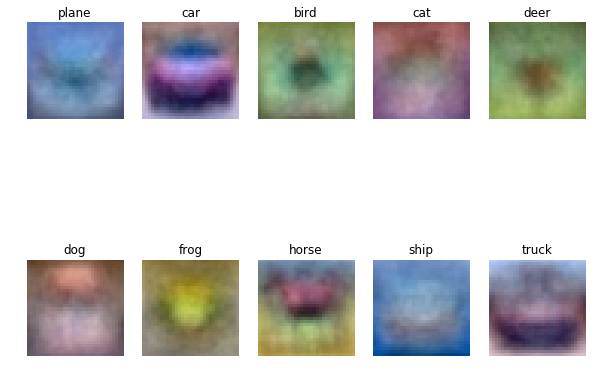

In [69]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])